In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, save_model
from keras.utils import np_utils

In [2]:
import os
import random
from keras import backend as K

#Set seed, so that every time you run, you will get the same (reproducible) results.
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
# Dataset is taken from https://www.kaggle.com/c/lish-moa/data
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [4]:
train_features.drop(['sig_id'], axis='columns', inplace=True)

In [5]:
train_features.loc[:, 'cp_type'] = train_features.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
train_features.loc[:, 'cp_dose'] = train_features.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})

In [6]:
test_features.loc[:, 'cp_type'] = test_features.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
test_features.loc[:, 'cp_dose'] = test_features.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})

In [7]:
train_targets_scored.drop(['sig_id'], axis='columns', inplace=True)

In [8]:
train_features_values = train_features.values
train_targets_values = train_targets_scored.values

In [9]:
input_dimension = train_features_values.shape[1]
output_dimension = train_targets_values.shape[1]

input_units = input_dimension
denselayer1_units = 128
denselayer2_units = 64
output_units = output_dimension

inputs = keras.Input(shape=input_units)
dense_layer1 = layers.Dense(denselayer1_units, activation="relu", name = "dense_layer1")(inputs)
dropout_layer1 = layers.Dropout(0.5, name = "dropout_layer1")(dense_layer1)
batch_normalization_layer1 = layers.BatchNormalization(name = "batch_normalization_layer1")(dropout_layer1)

dense_layer2 = layers.Dense(denselayer2_units, activation="relu", name = "dense_layer2")(batch_normalization_layer1)
dropout_layer2 = layers.Dropout(0.5, name = "dropout_layer2")(dense_layer2)
batch_normalization_layer2 = layers.BatchNormalization(name = "batch_normalization_layer2")(dropout_layer2)

outputs = layers.Dense(output_units, activation="sigmoid", name = "Output_Layer")(batch_normalization_layer2)

model = keras.Model(inputs=inputs, outputs=outputs, name="moa_model")

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

model.fit(train_features, train_targets_values, batch_size=100, epochs=75)

Epoch 1/75
239/239 [==============================] - 2s 5ms/step - loss: 0.5785 - accuracy: 0.0116
Epoch 2/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0454 - accuracy: 0.0183
Epoch 3/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0242 - accuracy: 0.0271
Epoch 4/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0222 - accuracy: 0.0385
Epoch 5/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0211 - accuracy: 0.0390
Epoch 6/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0434
Epoch 7/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0201 - accuracy: 0.0462
Epoch 8/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0199 - accuracy: 0.0490
Epoch 9/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0200 - accuracy: 0.0489
Epoch 10/75
239/239 [==============================] - 1s 5ms/step - loss: 0.0197 - accuracy: 0.0537

Model: "moa_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 875)]             0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 128)               112128    
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 128)               0         
_________________________________________________________________
batch_normalization_layer1 ( (None, 128)               512       
_________________________________________________________________
dense_layer2 (Dense)         (None, 64)                8256      
_________________________________________________________________
dropout_layer2 (Dropout)     (None, 64)                0         
_________________________________________________________________
batch_normalization_layer2 ( (None, 64)                25

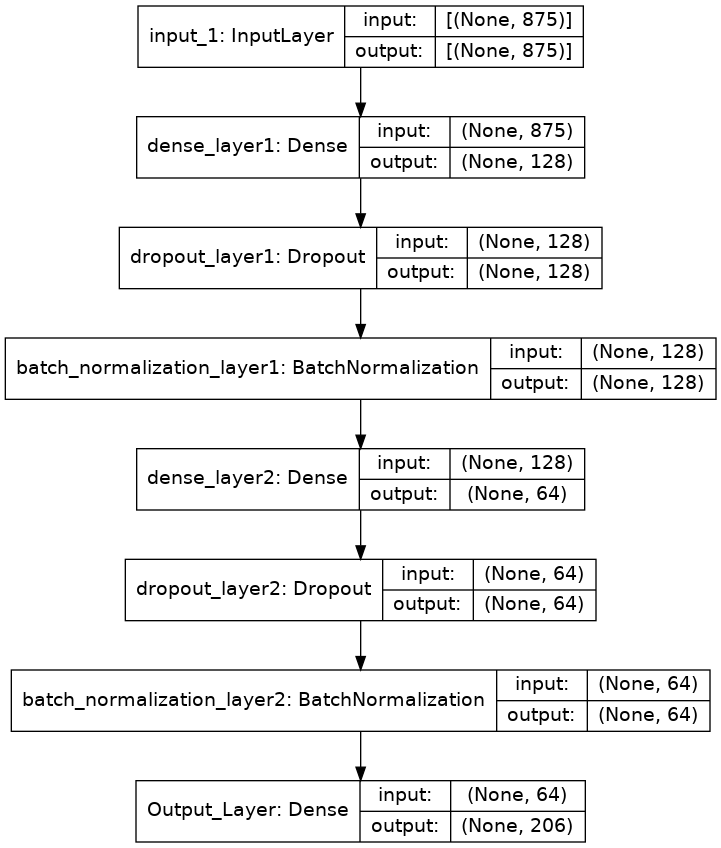

In [10]:
model.summary()
keras.utils.plot_model(model, show_shapes = True)

In [11]:
# Save the model (Serialization)
model.save('neural_network_model.h5', save_format='h5')

In [12]:
column_names = sample_submission.columns

In [13]:
test_id = x_test = test_features['sig_id'].values
x_test = test_features.drop(['sig_id'], axis='columns', inplace=False)

In [14]:
df = pd.DataFrame(x_test)

In [15]:
y_pred=model.predict(x_test)

In [16]:
id_list=[]
y_pred_list=[]
for i in range(len(y_pred)):
    id_list.append(test_id[i])
    y_pred_list.append(y_pred[i])

In [17]:
dictionary={}
for column in column_names:
    dictionary[column] = list()

In [18]:
column_names = list(column_names)
column_names.remove('sig_id')

In [19]:
dictionary['sig_id'] = test_id
for i in range(len(y_pred)):
    for j in range(len(column_names)):
        dictionary[column_names[j]].append(y_pred[i][j])

In [20]:
df=pd.DataFrame(dictionary)

In [21]:
df.to_csv('./submission.csv',index=False)